In [151]:
import pandas as pd
import numpy as np
import json
import persian
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import hazm

In [2]:
path = '/home/asma/Desktop/Divaar/javaneh_amlak/Amlak/'

validation = pd.read_csv(path + 'validation.csv')
train_labels = pd.read_csv(path + 'train_labels.csv')

action_logs = pd.read_parquet(path + 'action_logs.parquet')
ladder = pd.read_parquet(path + 'ladder.parquet')
posts = pd.read_parquet(path+ 'posts.parquet')

image_features = pd.read_csv(path+ 'images_features.csv').drop(['Unnamed: 0'], axis=1)

In [3]:
image_features = pd.read_csv(path+ 'images_features.csv').drop(['Unnamed: 0'], axis=1)
image_features = image_features.sort_values(by=['token', 'image_num']).reset_index(drop=True)
image_features = image_features.drop_duplicates(subset=['token'],keep='first')
image_features.head(3)

,dullness,whiteness,image_size,width,height,blurrness,token,image_num
0,0.0,2.365,68299,600,600,1809.952067,AY-RNJEr,0.jpg
9,0.0,0.000,90407,600,600,2881.315465,AY-ncLKW,0.jpg
10,36.2,44.145,69763,600,600,1394.461501,AY0DAuv8,0.jpg


In [4]:
action_logs = action_logs.reset_index(drop=True)
action_logs['ds'] = pd.to_datetime(action_logs['ds'])
action_logs['by_overuser'] = action_logs['by_overuser'].fillna(False)

In [5]:
def get_action_features(group):
    
    total = group.shape[0]
    clicks = group[group['action']=='click_post'].shape[0] 
    contacts = group[group['action']=='click_contact'].shape[0] / clicks
    bookmarks = group[group['action']=='click_bookmark'].shape[0]/ clicks
    by_overusers = group[group['by_overuser']].shape[0] / total
    
    return total, clicks, contacts, bookmarks, by_overusers

In [6]:
tokens_action = action_logs.groupby('token')\
                           .apply(lambda group: get_action_features(group))\
                           .reset_index()
tokens_action = pd.concat([tokens_action.drop(0 , axis=1), tokens_action[0].apply(pd.Series)], axis=1)\
                   .rename({0: 'total_actions', 1: 'clicks', 2: 'contacts', 3: 'bookmarks', 4: 'by_overusers'}, axis=1)

In [42]:
def fake_percenatge (data, feature):
    
    fakes = data[data['result']=='fake-post'].groupby([feature])['token'].count().reset_index().rename({'token':'fake-post'},axis=1)
    total = data.groupby([feature])['token'].count().reset_index().rename({'token':'total-post'},axis=1)
    total_fakes = data[data['result']=='fake-post'].shape[0]
    total = total.merge(fakes, on=feature, how='left')
    total['value_fake_prcentage'] = total['fake-post'] / total['total-post'] * 100
    #total = total.fillna(0)
    total['fake_percentage'] = total['fake-post'] / total_fakes * 100
    
    return total.sort_values(by='fake_percentage', ascending=False)

In [8]:
def find_pre_category(posts):
    
    residential_sell = ['apartment-sell', 'house-villa-sell', 'plot-old']
    residential_rent = ['apartment-rent', 'house-villa-rent']
    commercial_sell  = ['office-sell', 'shop-sell','industry-agriculture-business-sell']
    commercial_rent  = ['office-rent', 'shop-rent','industry-agriculture-business-rent']
    short_term_rent  = ['suite-apartment', 'villa', 'workspace'] 
    construction     = ['partnership', 'presell']

    conditions = [
        posts['category'].isin(residential_sell),
        posts['category'].isin(residential_rent),
        posts['category'].isin(commercial_sell),
        posts['category'].isin(commercial_rent),
        posts['category'].isin(short_term_rent),
        posts['category'].isin(construction)]
    
    choices = ['residential_sell', 'residential_rent', 'commercial_sell', 'commercial_rent', 'short_term_rent', 'construction' ]
    
    posts['pre_category'] = np.select(condlist=conditions, choicelist=choices, default='other')
    
    return posts['pre_category']

In [9]:
def extract_from_data_posts(posts_data):
    
    posts = posts_data.copy()
    
    posts['data'] = posts['data'].apply(lambda x:json.loads(x))
    posts = pd.concat([posts.drop(['data'], axis=1), posts['data'].apply(pd.Series)], axis=1)
    #posts = pd.concat([posts.drop(['price'], axis=1), posts['price'].apply(pd.Series)], axis=1)
    #posts.drop(0,inplace = True,axis = 1)
    #posts.value = posts.value/(10**6)
    cat = posts.category.iloc[:,1]
    posts.drop('category',inplace = True,axis = 1)
    posts['category'] = cat
    drop_columns = ['job_title', 'exchange', 'deed_type', 'bizzDeed', 'zoonkan_enabled',\
                    'national_id', 'property_type', 'daily_rent', 'desc']
    posts = posts.drop(drop_columns, axis=1, errors='ignore')
    
    return posts                              

In [10]:
def extract_from_contact(data):
    
    conditions = [
        data['contact']=={'chat_enable': 'false', 'chat_enabled': False},
        data['contact']=={'hide_phone': False, 'chat_enabled': True},
        (data['contact']!={'chat_enabled': False}) & (data['contact']!={'chat_enabled': True})]
    
    choices = [
        {'chat_enabled': False},
        {'chat_enabled': True},
        {'chat_enabled': False}]
    
    data['contact'] = np.select(condlist=conditions, choicelist=choices, default= data['contact']) 
    data = pd.concat([data.drop(['contact'], axis=1), data['contact'].apply(pd.Series)], axis=1)
    
    return data['chat_enabled'].astype(int)

In [11]:
def handle_year (data):
    
    string_year = 'قبل از ۱۳۷۰'
    data['year'] = np.where(data['year']== string_year, 1369, data['year'])
    data['year'] = data['year'].apply(lambda x:persian.convert_fa_numbers(x))
    data['year'] = np.where(data['year']=='nan', -1, data['year'])
    data['year'] = pd.to_numeric(data['year'])
    
    return data['year']

In [12]:
def find_username_category(group):
    
    #print(group)
    total_posts = group.shape[0]
    fake_posts = group[group['result']=='fake-post'].shape[0]
    min_posts = 3
    min_fake_ratio = 0.5
    username_category = "defult"
    
    if (total_posts<min_posts):
        username_category = 'without_history'
        
    elif ((fake_posts/ total_posts) > min_fake_ratio):
        username_category = 'KOSKESH'
        
    else:
        username_category = 'Ok'

    return username_category       

In [13]:
def username_category (data):
    
    data = data.copy()
    username_df = data.groupby(['username'])\
                        .apply(lambda group:find_username_category(group))\
                        .reset_index()\
                        .rename({0:'username_category'}, axis=1)

    data = data.merge(username_df, on='username', how='left')
    
    return data['username_category']

In [14]:
def is_rent(data):
    
    conditions = [
        ((data['pre_category'] == 'residential_sell')|
        (data['pre_category'] == 'commercial_sell') |
        (data['pre_category'] == 'construction')    |
        (data['pre_category'] == 'short_term_rent'))]
    
    choices = [0]
    
    data['is_rent'] = np.select(condlist= conditions, choicelist=choices, default=1)
    
    return data['is_rent']

In [15]:
def rent_features(data):
    
    data = data.copy()
    data['rent_credit_transform'] = np.where(data['is_rent']==0, 'sell', data['rent_credit_transform'])
    data['rent_to_single'] = np.where(data['is_rent']==0, 'sell', data['rent_to_single'])
    data['rent_type'] = np.where(data['is_rent']==0, 'sell', data['rent_type'])
    data['rent_to_single'] = data['rent_to_single'].fillna('false')
    
    return data

In [16]:
def handle_image_featuters(data):
    
    data = data.copy()
    blurriness_median = data['blurrness'].median()
    width_median = data['width'].median()
    
    b_conditions = [
        (data['blurrness'].isnull()),
        (data['blurrness']<=blurriness_median),
        (data['blurrness']>blurriness_median)]
    
    b_choices = [
        'no_images',
        'low_blurrness',
        'high_blurness']
    
    w_conditions = [
        (data['width'].isnull()),
        (data['width']<=width_median),
        (data['width']>width_median)]
    
    w_choices = [
        'no_images',
        'low_width',
        'high_width']
    
    data['blurriness_cat'] = np.select(condlist=b_conditions, choicelist=b_choices)
    data['width_cat'] = np.select(condlist=w_conditions, choicelist=w_choices)
 
    
    
    return data['blurriness_cat'], data['width_cat']

In [17]:
def handle_actions_features(data):
    
    data = data.copy()
    
    contact_median = data['contacts'].median()
    by_overuser_q3 = data['by_overusers'].quantile(0.75)
    bookmarks_median = data['bookmarks'].median()
    
    data['contacts_boolean'] = np.where(data['contacts']< contact_median, 0, 1) 
    data['by_overuser_boolean'] = np.where(data['by_overusers']> by_overuser_q3, 0, 1)
    data['bookmark_boolean'] = np.where(data['bookmarks']< bookmarks_median, 0, 1)

    return data['contacts_boolean'], data['by_overuser_boolean'], data['bookmark_boolean']

In [18]:
def find_price(row):
    if (row['is_rent']):
        row['new_credit'] = row['new_credit'] +  (row['new_rent']/3000000) * 100000000
        price = row['new_credit']* 6
    else:
        price = row['new_price']
    
    return np.log(price)

In [137]:
def preprocess(data):
    
    data = data.copy()
    
    data = extract_from_data_posts(data)
    data['contacts_boolean'], data['by_overuser_boolean'], data['bookmark_boolean'] = handle_actions_features(data)
    data['blurriness_cat'], data['width_cat'] = handle_image_featuters(data)
    data['chat_enabled'] = extract_from_contact(data)
    data['year'] = handle_year(data)

    data['full_options'] = np.where(((data['parking']=='true')\
                                     & (data['elevator']=='true')\
                                     & (data['warehouse']=='true')), 1, 0) 

    data['is_new'] = np.where(data['year']>1390, 1, 0)
    data['pre_category'] = find_pre_category(data)    
    data['is_rent'] = is_rent(data)
    data = rent_features(data)
    
    data['published_year'] = data['first_published_at'].dt.year
    data['published_dayofweek'] = data['first_published_at'].dt.dayofweek
    data['published_hour'] = data['first_published_at'].dt.hour
    data['published_year'] = np.where(data['published_year']<2021, 2021, data['published_year'])
    data['published_year'] = np.where(data['published_year']==2021, 0, 1)
    data['published_month'] = data['first_published_at'].dt.month
    data['published_season'] = np.where(data['published_month']<4, 1, 0)
    
    data['image_count'] = data['image_count'].astype(int)
    data['is_agent'] = np.where(data['username'].isnull(), 1, 0)
    data['is_tehran'] = np.where(data['city']=='tehran', 1, 0) 
    data['is_niavaran'] = np.where(data['district']=='niavaran', 1, 0)
    user_type_string = 'شخصی'
    data['user_type'] = np.where(data['user_type']==user_type_string, 0, 1) #is_agent
    
    
    data['total_price'] = data.apply(lambda row:  find_price(row), axis=1)
    data['total_price'] = data['total_price'].fillna(data['total_price'].median())
    
    
    return data

In [32]:
def train_preprocess(train_data):
    
    data = train_data.copy()
    ##for train_data
    data = data.dropna(subset=['first_published_at']).reset_index(drop=True)   
    drop_columns = ['tag', 'call_date']
    data.drop(drop_columns, axis=1, inplace=True)
    
    data['username_category'] = username_category(data)
    data['username_category'] = data['username_category'].fillna('without_history')

    
    return data

In [33]:
def validation_preprocess(validation_data, train_data):
    
    user_df = train_data[['username_category', 'username']].drop_duplicates(['username'])
    drop_columns = ['call_date']
    validation_data.drop(drop_columns, axis=1, inplace=True)
    #print(user_df.shape)
    validation_data = validation_data.merge(user_df, on='username', how='left')
    validation_data['username_category'] = validation_data['username_category'].fillna('without_history')
    
    return validation_data

In [139]:
train_posts = train_labels.merge(posts, on='token', how='left')
validation_posts = validation.merge(posts, on='token', how='left')

In [140]:
train_posts = train_posts.merge(image_features, on= 'token', how='left')
validation_posts = validation_posts.merge(image_features, on='token', how= 'left')

In [141]:
train_posts = train_posts.merge(tokens_action, on='token', how='left')
validation_posts = validation_posts.merge(tokens_action, on='token', how='left')

In [142]:
train_data = train_preprocess(train_posts)
validation_data =validation_preprocess(validation_posts, train_data)
train_data = preprocess(train_data)
validation_data = preprocess(validation_data)

In [38]:
train_data['contacts'].describe()

count    5999.000000
mean        0.055499
std         0.050881
min         0.000000
25%         0.022565
50%         0.040000
75%         0.071628
max         0.500000
Name: contacts, dtype: float64

In [39]:
bins = [-1, 0.02, 0.04, 0.07, 1]
labels = ['very_low', 'low', 'high', 'very_high']

train_data['contacts_bin'] = pd.cut(train_data['contacts'], bins= bins, labels= labels)

In [40]:
train_data['contacts_bin'].value_counts(dropna=False)

low          1737
very_high    1560
high         1423
very_low     1279
Name: contacts_bin, dtype: int64

In [43]:
fake_percenatge(train_data, 'contacts_bin')

,contacts_bin,total-post,fake-post,value_fake_prcentage,fake_percentage
1,low,1737,516,29.706390,28.304992
3,very_high,1560,516,33.076923,28.304992
2,high,1423,461,32.396346,25.287987
0,very_low,1279,330,25.801407,18.102030


In [44]:
train_data['by_overusers'].describe()

count    5999.000000
mean        0.109583
std         0.115870
min         0.000000
25%         0.052632
50%         0.073529
75%         0.112979
max         0.889764
Name: by_overusers, dtype: float64

In [45]:
bins = [-1, 0.05, 0.07, 0.11, 1]
labels = ['very_low', 'low', 'high', 'very_high']

train_data['by_overusers_bin'] = pd.cut(train_data['by_overusers'], bins= bins, labels= labels)

In [46]:
train_data['by_overusers_bin'].value_counts(dropna=False)

high         1643
very_high    1570
low          1478
very_low     1308
Name: by_overusers_bin, dtype: int64

In [47]:
fake_percenatge(train_data, 'by_overusers_bin')

,by_overusers_bin,total-post,fake-post,value_fake_prcentage,fake_percentage
1,low,1478,513,34.709066,28.140428
2,high,1643,510,31.040779,27.975864
0,very_low,1308,459,35.091743,25.178278
3,very_high,1570,341,21.719745,18.705431


In [48]:
train_data['clicks'].describe()

count     5999.000000
mean       538.497750
std       1106.724309
min          4.000000
25%        137.000000
50%        282.000000
75%        575.000000
max      39621.000000
Name: clicks, dtype: float64

In [49]:
bins = [-1, 137, 282, 575, 100000000]
labels = ['very_low', 'low', 'high', 'very_high']

train_data['clicks_bin'] = pd.cut(train_data['clicks'], bins= bins, labels= labels)

In [50]:
train_data['clicks_bin'].value_counts(dropna=False)

high         1502
very_low     1501
low          1500
very_high    1496
Name: clicks_bin, dtype: int64

In [51]:
fake_percenatge(train_data, 'clicks_bin')

,clicks_bin,total-post,fake-post,value_fake_prcentage,fake_percentage
0,very_low,1501,474,31.578947,26.001097
3,very_high,1496,469,31.350267,25.726824
2,high,1502,461,30.692410,25.287987
1,low,1500,419,27.933333,22.984092


In [52]:
train_data['bookmarks'].describe()

count    5999.000000
mean        0.039190
std         0.029401
min         0.000000
25%         0.017563
50%         0.033333
75%         0.054371
max         0.250000
Name: bookmarks, dtype: float64

In [53]:
bins = [-1, 0.017, 0.033, 0.05, 1]
labels = ['very_low', 'low', 'high', 'very_high']

train_data['bookmarks_bin'] = pd.cut(train_data['bookmarks'], bins= bins, labels= labels)

In [54]:
train_data['bookmarks_bin'].value_counts(dropna=False)

very_high    1744
low          1516
very_low     1447
high         1292
Name: bookmarks_bin, dtype: int64

In [55]:
fake_percenatge(train_data, 'bookmarks_bin')

,bookmarks_bin,total-post,fake-post,value_fake_prcentage,fake_percentage
3,very_high,1744,635,36.410550,34.832693
1,low,1516,405,26.715040,22.216127
2,high,1292,393,30.417957,21.557872
0,very_low,1447,390,26.952315,21.393308


In [56]:
train_data['total_actions'].describe()

count     5999.000000
mean       589.183864
std       1236.691687
min          5.000000
25%        150.000000
50%        308.000000
75%        627.000000
max      47195.000000
Name: total_actions, dtype: float64

In [57]:
bins = [-1, 150, 308, 627, 1000000000]
labels = ['very_low', 'low', 'high', 'very_high']

train_data['total_bin'] = pd.cut(train_data['total_actions'], bins= bins, labels= labels)

In [58]:
train_data['total_bin'].value_counts(dropna=False)

very_low     1508
high         1501
very_high    1498
low          1492
Name: total_bin, dtype: int64

In [59]:
fake_percenatge(train_data, 'total_bin')

,total_bin,total-post,fake-post,value_fake_prcentage,fake_percentage
3,very_high,1498,477,31.842457,26.165661
0,very_low,1508,471,31.233422,25.836533
2,high,1501,454,30.246502,24.904004
1,low,1492,421,28.217158,23.093801


In [62]:
train_data['image_size_boolean'] = np.where((train_data['image_size']<61000), 0, 1)
fake_percenatge(train_data, 'image_size_boolean')

,image_size_boolean,total-post,fake-post,value_fake_prcentage,fake_percentage
1,1,3583,1161,32.403014,63.686231
0,0,2416,662,27.400662,36.313769


In [64]:
train_data['dullness_boolean'] = np.where((train_data['dullness']<=2), 0, 1)
fake_percenatge(train_data, 'dullness_boolean')

,dullness_boolean,total-post,fake-post,value_fake_prcentage,fake_percentage
0,0,3349,1036,30.934607,56.829402
1,1,2650,787,29.698113,43.170598


In [66]:
train_data['whiteness_boolean'] = np.where(train_data['whiteness']<=9, 0, 1)
fake_percenatge(train_data, 'whiteness_boolean')

,whiteness_boolean,total-post,fake-post,value_fake_prcentage,fake_percentage
0,0,3611,1153,31.930213,63.247394
1,1,2388,670,28.056951,36.752606


In [67]:
train_data['dullness'].describe()

count    4857.000000
mean        8.284671
std        17.879739
min         0.000000
25%         0.000000
50%         0.000000
75%         6.600000
max       100.000000
Name: dullness, dtype: float64

In [68]:
train_data['dullness'].describe()

count    4857.000000
mean        8.284671
std        17.879739
min         0.000000
25%         0.000000
50%         0.000000
75%         6.600000
max       100.000000
Name: dullness, dtype: float64

In [69]:
train_data['whiteness'].describe()

count    4857.000000
mean        8.562178
std        16.478037
min         0.000000
25%         0.000000
50%         0.000000
75%         9.420000
max       100.000000
Name: whiteness, dtype: float64

In [70]:
train_data['blurrness'].describe()

count     4857.000000
mean       834.924080
std       1255.533285
min          3.341211
25%        178.639250
50%        402.015965
75%        985.427248
max      16054.349944
Name: blurrness, dtype: float64

In [71]:
train_data['image_size'].describe()

count      4857.000000
mean      75598.190859
std       50891.176372
min       10915.000000
25%       41627.000000
50%       61201.000000
75%       92691.000000
max      415653.000000
Name: image_size, dtype: float64

In [72]:
train_data['width'].describe()

count    4857.000000
mean      778.206506
std       218.923704
min       496.000000
25%       600.000000
50%       600.000000
75%      1000.000000
max      1200.000000
Name: width, dtype: float64

In [73]:
train_data['height'].describe()

count    4857.000000
mean      780.148240
std       220.106209
min       485.000000
25%       600.000000
50%       600.000000
75%       977.000000
max      1200.000000
Name: height, dtype: float64

In [74]:
train_data['height_boolean'] = np.where(train_data['height']<=600, 0, 1)
fake_percenatge(train_data, 'height_boolean')

,height_boolean,total-post,fake-post,value_fake_prcentage,fake_percentage
1,1,3564,1315,36.896745,72.133845
0,0,2435,508,20.862423,27.866155


/home/asma/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='width', ylabel='Density'>

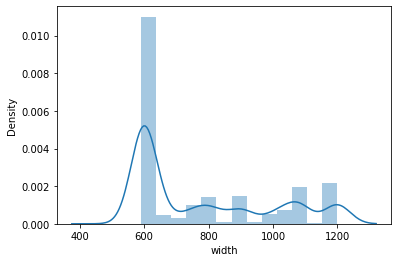

In [75]:
sns.distplot(train_data['width'])

/home/asma/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='blurrness', ylabel='Density'>

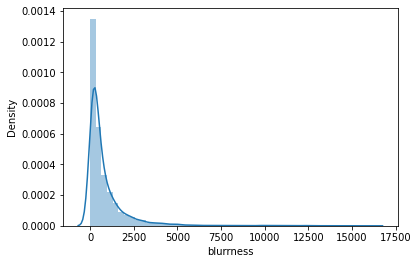

In [76]:
sns.distplot(train_data['blurrness'])

In [79]:
train_data['width_boolean'] = np.where(train_data['width']<=600, 0, 1)
fake_percenatge(train_data, 'width_boolean')

,width_boolean,total-post,fake-post,value_fake_prcentage,fake_percentage
1,1,3567,1316,36.893748,72.1887
0,0,2432,507,20.847039,27.8113


In [81]:
train_data['image_count'] = np.where(train_data['dullness'].isnull(), 0, train_data['image_count'])

In [82]:
validation_data['image_count'] = np.where(validation_data['dullness'].isnull(), 0, validation_data['image_count'])
validation_data = validation_data.fillna(0)

In [83]:
validation_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2171
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   token                  2172 non-null   object 
 1   image_count            2172 non-null   int64  
 2   dullness               2172 non-null   float64
 3   whiteness              2172 non-null   float64
 4   image_size             2172 non-null   float64
 5   width                  2172 non-null   float64
 6   height                 2172 non-null   float64
 7   blurrness              2172 non-null   float64
 8   total_actions          2172 non-null   float64
 9   clicks                 2172 non-null   float64
 10  contacts               2172 non-null   float64
 11  bookmarks              2172 non-null   float64
 12  by_overusers           2172 non-null   float64
 13  username_category      2172 non-null   object 
 14  size                   2172 non-null   float64
 15  year

In [84]:
train_data['blurriness_cat'].value_counts()

low_blurrness    2429
high_blurness    2428
no_images        1142
Name: blurriness_cat, dtype: int64

In [85]:
train_data['width_cat'].value_counts()

low_width     2432
high_width    2425
no_images     1142
Name: width_cat, dtype: int64

In [86]:
fake_percenatge(train_data, 'blurriness_cat')

,blurriness_cat,total-post,fake-post,value_fake_prcentage,fake_percentage
1,low_blurrness,2429,859,35.364347,47.120132
0,high_blurness,2428,663,27.306425,36.368623
2,no_images,1142,301,26.357268,16.511245


In [87]:
fake_percenatge(train_data, 'width_cat')

,width_cat,total-post,fake-post,value_fake_prcentage,fake_percentage
0,high_width,2425,1015,41.855670,55.677455
1,low_width,2432,507,20.847039,27.811300
2,no_images,1142,301,26.357268,16.511245


In [92]:
train_data['blurrness_boolean'] = np.where((train_data['blurrness']<400), 0, 1)
fake_percenatge(train_data, 'blurrness_boolean')

,blurrness_boolean,total-post,fake-post,value_fake_prcentage,fake_percentage
1,1,3580,967,27.011173,53.044432
0,0,2419,856,35.386523,46.955568


In [93]:
train_data[(train_data['result']=='fake-post') & (train_data['dullness']>0)].shape[0]

548

In [94]:
train_data_x = train_data.dropna().copy()
train_data_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 56 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   token                  0 non-null      object  
 1   result                 0 non-null      object  
 2   image_count            0 non-null      int64   
 3   dullness               0 non-null      float64 
 4   whiteness              0 non-null      float64 
 5   image_size             0 non-null      float64 
 6   width                  0 non-null      float64 
 7   height                 0 non-null      float64 
 8   blurrness              0 non-null      float64 
 9   total_actions          0 non-null      float64 
 10  clicks                 0 non-null      float64 
 11  contacts               0 non-null      float64 
 12  bookmarks              0 non-null      float64 
 13  by_overusers           0 non-null      float64 
 14  username_category      0 non-null      object  
 15  s

In [95]:
train_data_x['image_size_boolean'] = np.where((train_data_x['image_size']<61000), 0, 1)
fake_percenatge(train_data_x, 'image_size_boolean')

,total-post,image_size_boolean,fake-post,value_fake_prcentage,fake_percentage


In [96]:
train_data_x['dullness_boolean'] = np.where((train_data_x['dullness']<=2), 0, 1)
fake_percenatge(train_data_x, 'dullness_boolean')

,total-post,dullness_boolean,fake-post,value_fake_prcentage,fake_percentage


In [97]:
train_data_x['whiteness_boolean'] = np.where(train_data_x['whiteness']<=9, 0, 1)
fake_percenatge(train_data_x, 'whiteness_boolean')

,total-post,whiteness_boolean,fake-post,value_fake_prcentage,fake_percentage


In [98]:
train_data['dullness'].describe()

count    4857.000000
mean        8.284671
std        17.879739
min         0.000000
25%         0.000000
50%         0.000000
75%         6.600000
max       100.000000
Name: dullness, dtype: float64

In [99]:
train_data['dullness'].describe()

count    4857.000000
mean        8.284671
std        17.879739
min         0.000000
25%         0.000000
50%         0.000000
75%         6.600000
max       100.000000
Name: dullness, dtype: float64

In [100]:
train_data['whiteness'].describe()

count    4857.000000
mean        8.562178
std        16.478037
min         0.000000
25%         0.000000
50%         0.000000
75%         9.420000
max       100.000000
Name: whiteness, dtype: float64

In [101]:
train_data['blurrness'].describe()

count     4857.000000
mean       834.924080
std       1255.533285
min          3.341211
25%        178.639250
50%        402.015965
75%        985.427248
max      16054.349944
Name: blurrness, dtype: float64

In [102]:
train_data['image_size'].describe()

count      4857.000000
mean      75598.190859
std       50891.176372
min       10915.000000
25%       41627.000000
50%       61201.000000
75%       92691.000000
max      415653.000000
Name: image_size, dtype: float64

In [103]:
train_data['width'].describe()

count    4857.000000
mean      778.206506
std       218.923704
min       496.000000
25%       600.000000
50%       600.000000
75%      1000.000000
max      1200.000000
Name: width, dtype: float64

In [104]:
train_data['height'].describe()

count    4857.000000
mean      780.148240
std       220.106209
min       485.000000
25%       600.000000
50%       600.000000
75%       977.000000
max      1200.000000
Name: height, dtype: float64

In [105]:
train_data['height_boolean'] = np.where(train_data['height']<=600, 0, 1)
fake_percenatge(train_data, 'height_boolean')

,height_boolean,total-post,fake-post,value_fake_prcentage,fake_percentage
1,1,3564,1315,36.896745,72.133845
0,0,2435,508,20.862423,27.866155


/home/asma/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='width', ylabel='Density'>

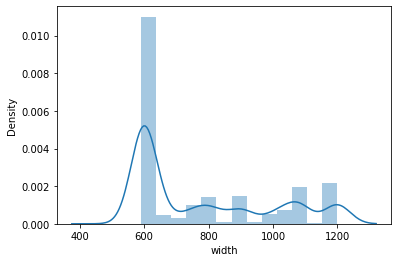

In [106]:
sns.distplot(train_data['width'])

/home/asma/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='blurrness', ylabel='Density'>

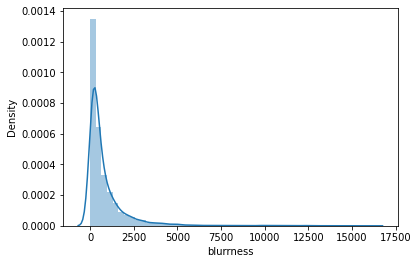

In [107]:
sns.distplot(train_data['blurrness'])

In [108]:
train_data_x['width_boolean'] = np.where(train_data_x['width']<=600, 0, 1)
fake_percenatge(train_data_x, 'width_boolean')

,total-post,width_boolean,fake-post,value_fake_prcentage,fake_percentage


In [110]:
train_data['rent_to_single'].value_counts(dropna=False)

sell     2932
false    1561
true     1506
Name: rent_to_single, dtype: int64

In [111]:
train_data['rent_credit_transform'].value_counts(dropna=False)

sell     2932
true     1778
false    1289
Name: rent_credit_transform, dtype: int64

In [112]:
train_data['rent_credit_transform'].value_counts(dropna=False)

sell     2932
true     1778
false    1289
Name: rent_credit_transform, dtype: int64

In [113]:
fake_percenatge(train_data, 'rent_to_single')

,rent_to_single,total-post,fake-post,value_fake_prcentage,fake_percentage
2,true,1506,746,49.535193,40.921558
0,false,1561,555,35.554132,30.444323
1,sell,2932,522,17.803547,28.634120


In [114]:
fake_percenatge(train_data, 'rent_credit_transform')

,rent_credit_transform,total-post,fake-post,value_fake_prcentage,fake_percentage
2,true,1778,818,46.006749,44.871092
1,sell,2932,522,17.803547,28.634120
0,false,1289,483,37.470908,26.494789


In [115]:
fake_percenatge(train_data, 'rent_type')

,rent_type,total-post,fake-post,value_fake_prcentage,fake_percentage
1,rent_credit,1510,679,44.966887,37.246297
2,sell,2932,522,17.803547,28.634120
0,full_credit,697,281,40.315638,15.414152


In [116]:
fake_percenatge(train_data, 'is_rent')

,is_rent,total-post,fake-post,value_fake_prcentage,fake_percentage
1,1,3067,1301,42.419302,71.36588
0,0,2932,522,17.803547,28.63412


In [117]:
fake_percenatge(train_data, 'pre_category')

,pre_category,total-post,fake-post,value_fake_prcentage,fake_percentage
3,residential_rent,2823,1263,44.739639,69.281404
4,residential_sell,2460,453,18.414634,24.849150
5,short_term_rent,273,50,18.315018,2.742732
0,commercial_rent,244,38,15.573770,2.084476
2,construction,64,11,17.187500,0.603401
1,commercial_sell,135,8,5.925926,0.438837


In [118]:
(train_data['new_rent']/ 1000000).describe()

count    2748.000000
mean       13.292326
std       222.899624
min         0.000000
25%         0.000000
50%         3.000000
75%         7.000000
max      9999.999999
Name: new_rent, dtype: float64

In [121]:
(train_data['new_credit']/ 1000000).describe()

count     2813.000000
mean       374.005990
std        616.728656
min          0.000000
25%        100.000000
50%        200.000000
75%        400.000000
max      10000.000000
Name: new_credit, dtype: float64

In [128]:
fake_percenatge(train_data, 'published_season')

,published_season,total-post,fake-post,value_fake_prcentage,fake_percentage
0,0,5040,1291,25.615079,70.817334
1,1,959,532,55.474453,29.182666


In [129]:
fake_percenatge(train_data, 'username_category')

,username_category,total-post,fake-post,value_fake_prcentage,fake_percentage
2,without_history,4757,1169,24.574312,64.125069
0,KOSKESH,637,497,78.021978,27.262754
1,Ok,605,157,25.950413,8.612178


In [133]:
fake_percenatge(train_data, 'full_options')

,full_options,total-post,fake-post,value_fake_prcentage,fake_percentage
1,1,2414,948,39.270920,52.002194
0,0,3585,875,24.407252,47.997806


In [134]:
train_data['username_category'].value_counts()

without_history    4757
KOSKESH             637
Ok                  605
Name: username_category, dtype: int64

In [143]:
train_data['username'].nunique()

1335

In [144]:
gdf = train_data.groupby(['username'])['token'].count().reset_index().sort_values(by='token', ascending= False)
gdf[gdf['token']>5].token.sum()

754

In [147]:
fake_percenatge(train_data, 'username')

,username,total-post,fake-post,value_fake_prcentage,fake_percentage
584,real-estate-business_3099,24,22.0,91.666667,1.206802
333,real-estate-business_1809,25,21.0,84.000000,1.151947
234,real-estate-business_1538,23,17.0,73.913043,0.932529
774,real-estate-business_5415,16,15.0,93.750000,0.822820
934,real-estate-business_8213,20,15.0,75.000000,0.822820
...,...,...,...,...,...
1324,real-estate-business_agent_94264,1,NaN,NaN,NaN
1326,real-estate-business_agent_95012,2,NaN,NaN,NaN
1329,real-estate-business_agent_95934,1,NaN,NaN,NaN
1333,real-estate-business_agent_99026,1,NaN,NaN,NaN


In [148]:
train_data['text'] = 'title: \n' + train_data['title'] + '\n' + 'description \n' + train_data['description'] + '\n' + 'end \n'

fake_texts = train_data[train_data['result']=='fake-post']['text']
ok_texts = train_data[train_data['result']=='ok']['text']

np.savetxt('fake_texts', fake_texts, fmt='%s')
np.savetxt('ok_texts', ok_texts, fmt='%s')

In [149]:
def count_real_words(text):
    words = hazm.word_tokenize(text)
    real_words = []
    
    for word in words:
        if (len(str(word)))>2:
            real_words.append(word)
            
    return real_words

In [152]:
train_data['words_count'] = train_data['text'].apply(lambda s: count_real_words(s))
train_data['words_count'].describe()

count                                                  5999
unique                                                 5997
top       [title, متر/تهرانپارس/تک, واحدی/کد, 183334, de...
freq                                                      2
Name: words_count, dtype: object

In [153]:
train_data[train_data['result']=='ok']['words_count'].describe()

count                                                  4176
unique                                                 4175
top       [title, متر, خوابه, فول, امکانات, ساله, بلوار,...
freq                                                      2
Name: words_count, dtype: object

In [154]:
train_data[train_data['result']=='fake-post']['words_count'].describe()

count                                                  1823
unique                                                 1823
top       [title, ۱۵۰, متر۲خواب, نیاوران, دسترسی, descri...
freq                                                      1
Name: words_count, dtype: object

In [155]:
suspicious_words = ['مشاور شما', 'فایل']

In [156]:
train_data['description_size'] = train_data['description'].apply(lambda s: len(s))
train_data['title_size'] = train_data['title'].apply(lambda s: len(s))

In [157]:
train_data['description_size'].describe()

count    5999.000000
mean      253.044507
std       187.497346
min         9.000000
25%       122.000000
50%       203.000000
75%       327.000000
max      1000.000000
Name: description_size, dtype: float64

In [158]:
train_data[train_data['result']=='ok']['description_size'].describe()

count    4176.000000
mean      253.156130
std       189.410394
min         9.000000
25%       121.000000
50%       202.000000
75%       329.000000
max      1000.000000
Name: description_size, dtype: float64

In [159]:
train_data[train_data['result']=='fake-post']['description_size'].describe()

count    1823.000000
mean      252.788810
std       183.090774
min        10.000000
25%       128.000000
50%       205.000000
75%       323.500000
max       998.000000
Name: description_size, dtype: float64

In [160]:
train_data['title_size'].describe()

count    5999.000000
mean       30.309718
std         9.834412
min         4.000000
25%        23.000000
50%        30.000000
75%        38.000000
max        50.000000
Name: title_size, dtype: float64

In [161]:
train_data[train_data['result']=='ok']['title_size'].describe()

count    4176.000000
mean       30.278017
std         9.892043
min         4.000000
25%        23.000000
50%        30.000000
75%        37.000000
max        50.000000
Name: title_size, dtype: float64

In [162]:
train_data[train_data['result']=='fake-post']['title_size'].describe()

count    1823.000000
mean       30.382337
std         9.703409
min         4.000000
25%        23.000000
50%        30.000000
75%        38.000000
max        50.000000
Name: title_size, dtype: float64

In [164]:
check_text = train_data[['result', 'title', 'description', 'other_options_and_attributes']]
check_text.to_csv('check_text.csv', index=False)

fake_titles = check_text[check_text['result']=='fake-post'][['description']]
ok_titles = check_text[check_text['result']=='ok'][['description']]

fake_titles['description'] = fake_titles['description']+'\n'+'@@@@@@@@@@@'
ok_titles['description'] = ok_titles['description']+'\n'+'@@@@@@@@@@@'

#fake_description = check_text[check_text['result']=='fake-post']['description']
np.savetxt('fake_title', fake_titles, fmt='%s')
np.savetxt('ok_title', ok_titles, fmt='%s')

In [165]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   token      6000 non-null   object
 1   call_date  6000 non-null   object
 2   result     6000 non-null   object
 3   tag        2539 non-null   object
dtypes: object(4)
memory usage: 187.6+ KB


In [166]:
train_labels['result'].value_counts()/train_labels.shape[0]

ok           0.696167
fake-post    0.303833
Name: result, dtype: float64

In [167]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   token      2172 non-null   object
 1   call_date  2172 non-null   object
dtypes: object(2)
memory usage: 34.1+ KB


In [168]:
validation['call_date'] = pd.to_datetime(validation['call_date'])
train_labels['call_date'] = pd.to_datetime(train_labels['call_date'])

In [169]:
print(validation['call_date'].min(),'\n' ,validation['call_date'].max())

2021-10-16 00:00:00 
 2022-02-06 00:00:00


In [170]:
print(train_labels['call_date'].min(),'\n' ,train_labels['call_date'].max())

2021-10-16 00:00:00 
 2022-02-06 00:00:00


In [171]:
ladder_count = ladder.groupby('token')['order_at'].count().reset_index().rename({'order_at': 'ladder_count'}, axis=1)

In [172]:
x = validation.merge(ladder_count,  on='token', how='left')

In [173]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2171
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   token         2172 non-null   object        
 1   call_date     2172 non-null   datetime64[ns]
 2   ladder_count  944 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 67.9+ KB


In [174]:
train_posts_first = train_labels.merge(posts, on='token', how='left')

In [175]:
ladder.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31229 entries, 0 to 31228
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   token     31229 non-null  object        
 1   order_at  31229 non-null  datetime64[ns]
 2   type      31229 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 975.9+ KB


In [176]:
def time_between_ladders(group):
    group = group.sort_values(by='order_at').reset_index(drop=True)
    return (group['order_at'] -  group['order_at'].shift(1)).dt.days

In [177]:
grouped_ladder = ladder.groupby(['token'])\
                        .apply(lambda group: time_between_ladders(group))\
                        .reset_index()\
                        .rename({'order_at': 'time_between'}, axis=1)\
                        .drop(['level_1'], axis=1)

grouped_ladder

,token,time_between
0,AY-RNJEr,NaN
1,AY-RNJEr,6.0
2,AY-RNJEr,9.0
3,AY-RNJEr,10.0
4,AY-RNJEr,10.0
...,...,...
31224,wXo8QU1Z,13.0
31225,wXo8QU1Z,8.0
31226,wXo8QU1Z,29.0
31227,wXo8QU1Z,30.0


In [178]:
grouped_ladder = grouped_ladder.groupby(['token'])['time_between'].max().reset_index()
grouped_ladder.head(5)

,token,time_between
0,AY-RNJEr,11.0
1,AY-ncLKW,42.0
2,AY0DAuv8,15.0
3,AY2mFWFP,13.0
4,AY6514xL,6.0


In [179]:
train_with_ladder = train_posts_first.merge(grouped_ladder, on='token', how='left')
train_with_ladder['time_between'].describe()

count    1781.000000
mean        7.504211
std         7.141083
min         0.000000
25%         3.000000
50%         6.000000
75%        10.000000
max        65.000000
Name: time_between, dtype: float64

In [180]:
fake_percenatge(train_with_ladder, 'time_between')

,time_between,total-post,fake-post,value_fake_prcentage,fake_percentage
1,1.0,148,69.0,46.621622,3.784970
3,3.0,182,57.0,31.318681,3.126714
2,2.0,154,51.0,33.116883,2.797586
4,4.0,153,50.0,32.679739,2.742732
5,5.0,167,37.0,22.155689,2.029622
0,0.0,84,33.0,39.285714,1.810203
6,6.0,120,30.0,25.000000,1.645639
8,8.0,111,27.0,24.324324,1.481075
7,7.0,137,24.0,17.518248,1.316511
10,10.0,60,16.0,26.666667,0.877674


In [181]:
# condtions = [
#     ((train_with_ladder['ladder_type']!='panel_reorder'])\
#       & (train_with_ladder['ladder_type']!=['reorder']))]

# choices = [-1]

ladder_type = ladder.groupby('token')['type'].unique().reset_index().rename({'type': 'ladder_type'}, axis=1)
train_with_ladder = train_posts_first.merge(ladder_type, on='token',how='left')
train_with_ladder['ladder_type'] = train_with_ladder['ladder_type'].str[0]

In [182]:
train_with_ladder['ladder_type'].value_counts()

reorder          1390
panel_reorder    1161
Name: ladder_type, dtype: int64

In [183]:
fake_percenatge(train_with_ladder, 'ladder_type')

,ladder_type,total-post,fake-post,value_fake_prcentage,fake_percentage
0,panel_reorder,1161,446,38.415159,24.465167
1,reorder,1390,278,20.000000,15.249589


In [184]:
ladder_count = ladder.groupby('token')['order_at'].count().reset_index().rename({'order_at': 'ladder_count'}, axis=1)
train_with_ladder = train_posts_first.merge(ladder_count, on='token',how='left')
train_with_ladder['ladder_count'].describe()

count    2551.000000
mean        9.092513
std        25.349975
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       741.000000
Name: ladder_count, dtype: float64

In [185]:
train_with_ladder['ladder_count'].value_counts(dropna=False)

NaN      3449
1.0       770
2.0       410
3.0       240
4.0       186
         ... 
86.0        1
163.0       1
118.0       1
141.0       1
103.0       1
Name: ladder_count, Length: 109, dtype: int64

In [186]:
train_with_ladder[(train_with_ladder['ladder_count']>3) & (train_with_ladder['result']=='fake-post')].shape

(289, 15)

In [187]:
conditions = [
    train_with_ladder['ladder_count'].isnull(),
    train_with_ladder['ladder_count']<=3,
    train_with_ladder['ladder_count']>3]

choices = [-1, 0, 1]

train_with_ladder['ladder'] = np.select(condlist=conditions, choicelist=choices)

In [188]:
train_with_ladder['ladder'].value_counts(dropna=False)

-1    3449
 0    1420
 1    1131
Name: ladder, dtype: int64

In [189]:
fake_percenatge(train_with_ladder, 'ladder').head(5)

,ladder,total-post,fake-post,value_fake_prcentage,fake_percentage
0,-1,3449,1099,31.864308,60.285244
1,0,1420,435,30.633803,23.861766
2,1,1131,289,25.552608,15.852990


In [190]:
train_posts_first['result'].value_counts()

ok           4177
fake-post    1823
Name: result, dtype: int64

In [191]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   token      2172 non-null   object        
 1   call_date  2172 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 34.1+ KB


In [192]:
validation_posts = validation.merge(posts, on='token', how='left')

In [193]:
validation_posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2171
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   token               2172 non-null   object        
 1   call_date           2172 non-null   datetime64[ns]
 2   first_published_at  2172 non-null   datetime64[ns]
 3   data                2172 non-null   object        
 4   image_count         2172 non-null   int16         
 5   device_id           2172 non-null   object        
 6   username            929 non-null    object        
 7   retiredAtUtc        0 non-null      object        
 8   city                2172 non-null   object        
 9   district            1667 non-null   object        
 10  category            2172 non-null   object        
 11  user_hash           2172 non-null   object        
dtypes: datetime64[ns](2), int16(1), object(9)
memory usage: 207.9+ KB


In [194]:
train_posts_first.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   token               6000 non-null   object        
 1   call_date           6000 non-null   datetime64[ns]
 2   result              6000 non-null   object        
 3   tag                 2539 non-null   object        
 4   first_published_at  5999 non-null   datetime64[ns]
 5   data                5999 non-null   object        
 6   image_count         5999 non-null   float64       
 7   device_id           5999 non-null   object        
 8   username            2594 non-null   object        
 9   retiredAtUtc        0 non-null      object        
 10  city                5999 non-null   object        
 11  district            4568 non-null   object        
 12  category            5999 non-null   object        
 13  user_hash           5999 non-null   object      

In [195]:
train_posts = train_posts_first.dropna(subset=['first_published_at']).copy()

In [196]:
train_posts['token'].nunique()

5999

In [197]:
train_posts['device_id'].nunique()

5348

In [198]:
train_posts['city'].nunique()

56

In [199]:
train_posts['district'].nunique()

292

In [200]:
train_posts['category'].nunique()

16

In [354]:
train_posts['size'].describe()

count    5.950000e+03
mean     2.471344e+03
std      1.316640e+05
min      1.000000e+00
25%      6.500000e+01
50%      9.000000e+01
75%      1.487500e+02
max      1.000000e+07
Name: size, dtype: float64

In [355]:
train_posts.isnull().sum()

token                              0
result                             0
first_published_at                 0
image_count                        0
device_id                          0
username                        3405
city                               0
district                        1431
rent                            2928
size                              49
year                             820
floor                           1641
rooms                            545
title                              0
credit                          2928
contact                            0
parking                         1074
elevator                        1641
new_rent                        3251
rent_type                       3789
user_type                          0
warehouse                       1074
new_credit                      3186
description                        0
rent_to_single                  3176
rent_credit_transform           2932
other_options_and_attributes    3552
p

In [356]:
train_posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5999 entries, 0 to 5999
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   token                         5999 non-null   object        
 1   result                        5999 non-null   object        
 2   first_published_at            5999 non-null   datetime64[ns]
 3   image_count                   5999 non-null   float64       
 4   device_id                     5999 non-null   object        
 5   username                      2594 non-null   object        
 6   city                          5999 non-null   object        
 7   district                      4568 non-null   object        
 8   rent                          3071 non-null   object        
 9   size                          5950 non-null   float64       
 10  year                          5179 non-null   object        
 11  floor                         

In [357]:
dic_columns = ['rent', 'contact', 'credit', 'other_options_and_attributes', 'price']

In [358]:
train_posts['title'].head(20)

0              آپارتمان 87 متری فول امکانات پهلوان حسن
1                         ۸۰متر فول امکانات شیک و زیبا
2               ۶۵متری یک خواب  بزرگ بدون پرتی غرق نور
3                                       دربستی ۱۸۰ متر
4                       50 متر مبله موقعیت اداری شرایط
5        ١٠٥متر٢خواب زینعلی/فول مشاعات/ورودی لابی مجلل
6                     ۷۰متر۲خ پارکینگ انباری روب افتاب
7     اجاره ویلای استخردار، ویلا استخردار ، اجاره ویلا
8                                زمین به مساحت 580 متر
9              رهن و اجاره / 120 متر پروژه مدرن بهاران
10                 خیابان حیدری ۶۰ متر ۲ خواب طبقه اول
11                       اپارتمان۱۲۰متری ۲خواب نیاوران
12                                     آپارتمان 63 متر
13        اجاره ویلا با امکانات و خدمات  فرح آباد ساری
14                   اپارتمان ۶۵ متری طبقه اول یک خواب
15            ٩٣متر دوخوابه برج مسکونی در پاسدار گمنام
16           آپارتمان ۱۰۵ متر سعادت آباد صرافهای شمالی
17                           60متر یک خواب  بلوار و131
18        

In [359]:
train_posts['rent_credit_transform'].value_counts(dropna=False)

NaN      2932
true     1778
false    1289
Name: rent_credit_transform, dtype: int64

In [360]:
train_posts['rent_credit_transform'] = train_posts['rent_credit_transform'].fillna(-1)
fake_percenatge(train_posts, 'rent_credit_transform')

,rent_credit_transform,total-post,fake-post,value_fake_prcentage,fake_percentage
2,true,1778,818,46.006749,44.871092
0,-1,2932,522,17.803547,28.634120
1,false,1289,483,37.470908,26.494789


In [361]:
train_posts['rent_to_single'].value_counts()

true     1506
false    1317
Name: rent_to_single, dtype: int64

In [362]:
train_posts['rent_to_single'] = train_posts['rent_to_single'].fillna(-1)
fake_percenatge(train_posts, 'rent_to_single')

,rent_to_single,total-post,fake-post,value_fake_prcentage,fake_percentage
2,true,1506,746,49.535193,40.921558
0,-1,3176,560,17.632242,30.718596
1,false,1317,517,39.255885,28.359846


In [363]:
train_posts['user_type'].value_counts(dropna=False)

مشاور املاک    4088
شخصی           1911
Name: user_type, dtype: int64

In [364]:
fake_percenatge(train_posts, 'user_type')

,user_type,total-post,fake-post,value_fake_prcentage,fake_percentage
1,مشاور املاک,4088,1512,36.986301,82.940208
0,شخصی,1911,311,16.274202,17.059792


In [365]:
train_posts['rent_type'].value_counts(dropna=False)

NaN            3789
rent_credit    1512
full_credit     698
Name: rent_type, dtype: int64

In [366]:
apartment_rent_df = train_posts[train_posts['category']=='apartment-rent'].copy()

In [367]:
train_posts['city'].nunique()

56

In [368]:
apartment_rent_df['rent_type'].fillna(-1, inplace=True)
fake_percenatge(apartment_rent_df, 'rent_type')

,rent_type,total-post,fake-post,value_fake_prcentage,fake_percentage
2,rent_credit,1277,625,48.942835,51.567657
0,-1,737,312,42.333786,25.742574
1,full_credit,655,275,41.984733,22.689769


In [369]:
train_posts['parking'].value_counts(dropna=False)

true     3797
false    1128
NaN      1074
Name: parking, dtype: int64

In [370]:
train_posts['full_options'] = np.where(((train_posts['parking']=='true')\
                                        & (train_posts['elevator']=='true') & (train_posts['warehouse']=='true')), 'true', 'false')

In [371]:
train_posts['full_options'].value_counts(dropna=False)

false    3585
true     2414
Name: full_options, dtype: int64

In [372]:
fake_percenatge(train_posts, 'full_options')

,full_options,total-post,fake-post,value_fake_prcentage,fake_percentage
1,true,2414,948,39.270920,52.002194
0,false,3585,875,24.407252,47.997806


In [373]:
x= train_posts.fillna({'parking': -1})
fake_percenatge(x, 'parking')

,parking,total-post,fake-post,value_fake_prcentage,fake_percentage
2,true,3797,1338,35.238346,73.395502
1,false,1128,329,29.166667,18.047175
0,-1,1074,156,14.525140,8.557323


In [374]:
x= train_posts.fillna({'elevator': -1})
fake_percenatge(x, 'elevator')

,elevator,total-post,fake-post,value_fake_prcentage,fake_percentage
2,true,3076,1151,37.418726,63.137685
1,false,1282,380,29.641186,20.844761
0,-1,1641,292,17.794028,16.017553


In [375]:
train_posts['warehouse'].value_counts()

true     4153
false     772
Name: warehouse, dtype: int64

In [376]:
train_posts['warehouse'] = train_posts['warehouse'].fillna(-1)
fake_percenatge(train_posts, 'warehouse')

,warehouse,total-post,fake-post,value_fake_prcentage,fake_percentage
2,true,4153,1460,35.155309,80.087767
1,false,772,207,26.813472,11.354909
0,-1,1074,156,14.525140,8.557323


In [379]:
train_posts['chat_enabled'].value_counts()

True     3057
False    2942
Name: chat_enabled, dtype: int64

In [381]:
train_posts['chat_enabled'].value_counts(dropna=False)

True     3057
False    2942
Name: chat_enabled, dtype: int64

In [382]:
fake_percenatge(train_posts,'chat_enabled')

,chat_enabled,total-post,fake-post,value_fake_prcentage,fake_percentage
0,False,2942,1046,35.554045,57.377948
1,True,3057,777,25.417076,42.622052


In [383]:
train_posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5999 entries, 0 to 5999
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   token                         5999 non-null   object        
 1   result                        5999 non-null   object        
 2   first_published_at            5999 non-null   datetime64[ns]
 3   image_count                   5999 non-null   float64       
 4   device_id                     5999 non-null   object        
 5   username                      2594 non-null   object        
 6   city                          5999 non-null   object        
 7   district                      4568 non-null   object        
 8   rent                          3071 non-null   object        
 9   size                          5950 non-null   float64       
 10  year                          5179 non-null   object        
 11  floor                         

In [384]:
fake_percenatge(train_posts, 'chat_enabled')

,chat_enabled,total-post,fake-post,value_fake_prcentage,fake_percentage
0,False,2942,1046,35.554045,57.377948
1,True,3057,777,25.417076,42.622052


In [385]:
x = train_posts[(train_posts['elevator']=='false') & (train_posts['floor']!='+30')]
x['floor'].value_counts()

2     376
1     322
3     308
0     125
4     110
-1     33
5       8
Name: floor, dtype: int64

In [386]:
fake_percenatge(x, 'floor')

,floor,total-post,fake-post,value_fake_prcentage,fake_percentage
3,2,376,111,29.521277,29.210526
4,3,308,95,30.844156,25.000000
2,1,322,91,28.260870,23.947368
1,0,125,36,28.800000,9.473684
5,4,110,34,30.909091,8.947368
0,-1,33,12,36.363636,3.157895
6,5,8,1,12.500000,0.263158


In [387]:
train_posts['floor'].value_counts()

2      998
3      938
1      878
4      647
5      402
0      170
6      115
8       39
7       38
-1      36
10      28
9       25
14      10
11       9
13       5
19       4
12       4
15       3
20       3
16       2
26       2
18       1
30+      1
Name: floor, dtype: int64

In [388]:
fake_percenatge(train_posts, 'floor')

,floor,total-post,fake-post,value_fake_prcentage,fake_percentage
12,2,998,333.0,33.366733,18.266594
15,3,938,331.0,35.287846,18.156884
2,1,878,291.0,33.143508,15.962699
17,4,647,222.0,34.312210,12.177729
18,5,402,158.0,39.303483,8.667032
19,6,115,62.0,53.913043,3.400987
1,0,170,47.0,27.647059,2.578168
20,7,38,22.0,57.894737,1.206802
21,8,39,16.0,41.025641,0.877674
0,-1,36,14.0,38.888889,0.767965


In [389]:
string_year = 'قبل از ۱۳۷۰'
train_posts['year'] = np.where(train_posts['year']== string_year, 1361, train_posts['year'])
train_posts['year'] = train_posts['year'].apply(lambda x:persian.convert_fa_numbers(x))
train_posts['year'] = np.where(train_posts['year']=='nan', -1, train_posts['year'])
train_posts['year'] = pd.to_numeric(train_posts['year'])

In [390]:
train_posts['year'].value_counts()

-1       820
 1400    797
 1395    391
 1390    367
 1385    348
 1399    320
 1396    286
 1398    271
 1394    227
 1397    227
 1388    211
 1392    210
 1393    206
 1380    193
 1387    150
 1386    132
 1389    130
 1391    116
 1361    115
 1384    101
 1383     94
 1382     65
 1375     52
 1381     46
 1371     27
 1379     22
 1378     20
 1374     17
 1372     16
 1377     12
 1373      6
 1376      4
Name: year, dtype: int64

In [391]:
train_posts['year'].describe()

count    5999.000000
mean     1201.024837
std       478.395432
min        -1.000000
25%      1383.000000
50%      1391.000000
75%      1397.000000
max      1400.000000
Name: year, dtype: float64

In [392]:
train_posts['year_mode5'] = np.where((train_posts['year']%5==0), 0 , 1)

In [393]:
fake_percenatge(train_posts,'year_mode5')

,year_mode5,total-post,fake-post,value_fake_prcentage,fake_percentage
1,1,3851,1081,28.070631,59.297861
0,0,2148,742,34.543762,40.702139


In [394]:
fake_percenatge(train_posts,'year')

,year,total-post,fake-post,value_fake_prcentage,fake_percentage
31,1400,797,270.0,33.877039,14.810752
26,1395,391,156.0,39.897698,8.557323
21,1390,367,125.0,34.059946,6.856829
0,-1,820,124.0,15.121951,6.801975
16,1385,348,113.0,32.471264,6.198574
29,1398,271,102.0,37.638376,5.595173
30,1399,320,97.0,30.312500,5.320900
27,1396,286,95.0,33.216783,5.211190
28,1397,227,82.0,36.123348,4.498080
25,1394,227,74.0,32.599119,4.059243


In [395]:
train_posts['is_new'] = np.where(train_posts['year']>1390, 1, 0)

In [396]:
fake_percenatge(train_posts, 'is_new')

,is_new,total-post,fake-post,value_fake_prcentage,fake_percentage
1,1,3051,1050,34.414946,57.597367
0,0,2948,773,26.221167,42.402633


In [397]:
apartment_rent_df['size'].describe()

count    2669.000000
mean      103.263395
std        60.635162
min        14.000000
25%        65.000000
50%        85.000000
75%       120.000000
max       900.000000
Name: size, dtype: float64

In [398]:
conditions = [
    apartment_rent_df['size']<=65,
    (apartment_rent_df['size']>65) & (apartment_rent_df['size']<=85),
    (apartment_rent_df['size']>85) & (apartment_rent_df['size']<=120),
    (apartment_rent_df['size']>120) & (apartment_rent_df['size']<=150),
    apartment_rent_df['size']>150]


choices = ['x_small','small', 'medium','large', 'x_large']

apartment_rent_df['size_cat'] = np.select(condlist=conditions, choicelist=choices)
apartment_rent_df['size_cat'].value_counts()

x_small    758
medium     634
small      612
x_large    371
large      294
Name: size_cat, dtype: int64

In [399]:
fake_percenatge(apartment_rent_df, 'size_cat')

,size_cat,total-post,fake-post,value_fake_prcentage,fake_percentage
4,x_small,758,310,40.897098,25.577558
3,x_large,371,251,67.654987,20.709571
1,medium,634,249,39.274448,20.544554
2,small,612,234,38.235294,19.306931
0,large,294,168,57.142857,13.861386


In [400]:
train_posts['rooms'].value_counts()

دو              2571
یک              1511
سه               896
بدون اتاق        266
چهار             142
پنج یا بیشتر      68
Name: rooms, dtype: int64

In [401]:
fake_percenatge(train_posts, 'rooms')

,rooms,total-post,fake-post,value_fake_prcentage,fake_percentage
1,دو,2571,799,31.077402,43.828854
5,یک,1511,450,29.781602,24.684586
2,سه,896,360,40.178571,19.747669
4,چهار,142,70,49.295775,3.839824
0,بدون اتاق,266,51,19.172932,2.797586
3,پنج یا بیشتر,68,19,27.941176,1.042238


In [402]:
train_posts['pre_category'] = find_pre_category(train_posts)

In [403]:
train_posts['published_year'] = train_posts['first_published_at'].dt.year
train_posts['published_dayofweek'] = train_posts['first_published_at'].dt.dayofweek
train_posts['published_hour'] = train_posts['first_published_at'].dt.hour
train_posts['published_month'] = train_posts['first_published_at'].dt.month

In [404]:
fake_percenatge(train_posts, 'published_month')

,published_month,total-post,fake-post,value_fake_prcentage,fake_percentage
10,11,2126,554.0,26.058325,30.389468
0,1,888,493.0,55.518018,27.043335
11,12,1390,440.0,31.654676,24.136039
9,10,1307,253.0,19.357307,13.878223
1,2,68,38.0,55.882353,2.084476
8,9,146,29.0,19.863014,1.590784
7,8,31,6.0,19.354839,0.329128
5,6,12,5.0,41.666667,0.274273
6,7,18,3.0,16.666667,0.164564
2,3,3,1.0,33.333333,0.054855


In [405]:
fake_percenatge(train_posts, 'published_dayofweek')

,published_dayofweek,total-post,fake-post,value_fake_prcentage,fake_percentage
2,2,879,308,35.039818,16.895228
0,0,996,301,30.220884,16.511245
5,5,956,299,31.276151,16.401536
6,6,969,284,29.308566,15.578716
1,1,909,262,28.822882,14.371914
3,3,796,242,30.402010,13.274822
4,4,494,127,25.708502,6.966539


In [406]:
fake_percenatge(train_posts, 'published_year')

,published_year,total-post,fake-post,value_fake_prcentage,fake_percentage
2,2021,5041,1293.0,25.649673,70.927043
3,2022,949,529.0,55.742887,29.018102
1,2020,7,1.0,14.285714,0.054855
0,2019,2,0.0,0.000000,0.000000


In [407]:
fake_percenatge(train_posts, 'published_hour')

,published_hour,total-post,fake-post,value_fake_prcentage,fake_percentage
11,11,720,235.0,32.638889,12.890839
12,12,652,231.0,35.429448,12.671421
10,10,484,154.0,31.818182,8.447614
13,13,487,152.0,31.211499,8.337905
17,17,460,149.0,32.391304,8.173341
18,18,432,129.0,29.861111,7.076248
16,16,357,119.0,33.333333,6.527702
15,15,330,111.0,33.636364,6.088865
19,19,323,104.0,32.198142,5.704882
14,14,385,98.0,25.454545,5.375754


In [408]:
train_posts['is_agent'] = np.where(train_posts['username'].isnull(), 0, 1)
fake_percenatge(train_posts, 'is_agent')

,is_agent,total-post,fake-post,value_fake_prcentage,fake_percentage
1,1,2594,1107,42.675405,60.724081
0,0,3405,716,21.027900,39.275919


In [409]:
fake_percenatge(train_posts, 'pre_category')

,pre_category,total-post,fake-post,value_fake_prcentage,fake_percentage
3,residential_rent,2823,1263,44.739639,69.281404
4,residential_sell,2460,453,18.414634,24.849150
5,short_term_rent,273,50,18.315018,2.742732
0,commercial_rent,244,38,15.573770,2.084476
2,construction,64,11,17.187500,0.603401
1,commercial_sell,135,8,5.925926,0.438837


In [410]:
fake_percenatge(train_posts, 'category')

,category,total-post,fake-post,value_fake_prcentage,fake_percentage
0,apartment-rent,2669,1212.0,45.410266,66.483818
1,apartment-sell,1599,306.0,19.136961,16.785518
3,house-villa-sell,413,85.0,20.581114,4.662644
9,plot-old,448,62.0,13.839286,3.400987
2,house-villa-rent,154,51.0,33.116883,2.797586
13,suite-apartment,154,28.0,18.181818,1.535930
11,shop-rent,145,22.0,15.172414,1.206802
14,villa,115,22.0,19.130435,1.206802
6,office-rent,70,13.0,18.571429,0.713110
10,presell,51,9.0,17.647059,0.493692


In [411]:
fake_percenatge(train_posts, 'image_count')

,image_count,total-post,fake-post,value_fake_prcentage,fake_percentage
1,1.0,1121,541,48.260482,29.676358
0,0.0,1106,297,26.853526,16.291827
2,2.0,492,201,40.853659,11.025782
3,3.0,465,147,31.612903,8.063631
5,5.0,477,138,28.930818,7.569940
4,4.0,458,122,26.637555,6.692265
6,6.0,381,92,24.146982,5.046626
7,7.0,340,80,23.529412,4.388371
8,8.0,240,44,18.333333,2.413604
10,10.0,241,41,17.012448,2.249040


In [412]:
fake_percenatge(train_posts, 'year')

,year,total-post,fake-post,value_fake_prcentage,fake_percentage
31,1400,797,270.0,33.877039,14.810752
26,1395,391,156.0,39.897698,8.557323
21,1390,367,125.0,34.059946,6.856829
0,-1,820,124.0,15.121951,6.801975
16,1385,348,113.0,32.471264,6.198574
29,1398,271,102.0,37.638376,5.595173
30,1399,320,97.0,30.312500,5.320900
27,1396,286,95.0,33.216783,5.211190
28,1397,227,82.0,36.123348,4.498080
25,1394,227,74.0,32.599119,4.059243


In [413]:
city_fake_percentage =fake_percenatge(train_posts, 'city')
city_fake_percentage[city_fake_percentage['fake_percentage']>1]

,city,total-post,fake-post,value_fake_prcentage,fake_percentage
53,tehran,4568,1553.0,33.997373,85.189248
43,rasht,323,58.0,17.956656,3.181569
22,gorgan,166,34.0,20.481928,1.865058


In [414]:
train_posts['is_tehran'] = np.where(train_posts['city']=='tehran', 1, 0)
fake_percenatge(train_posts, 'is_tehran')

,is_tehran,total-post,fake-post,value_fake_prcentage,fake_percentage
1,1,4568,1553,33.997373,85.189248
0,0,1431,270,18.867925,14.810752


In [415]:
fake_percenatge(train_posts, 'district').sort_values(by='total-post', ascending=False).head(10)

,district,total-post,fake-post,value_fake_prcentage,fake_percentage
66,east-tehranpars,782,305.0,39.002558,16.730664
162,niavaran,722,551.0,76.315789,30.224904
226,shahrak-e-vali-e-asr,160,66.0,41.250000,3.620406
176,pardis,119,37.0,31.092437,2.029622
174,parand,94,19.0,20.212766,1.042238
231,shahriar,84,12.0,14.285714,0.658256
17,andisheh,77,17.0,22.077922,0.932529
179,poonak,74,19.0,25.675676,1.042238
281,west-tehranpars,69,18.0,26.086957,0.987383
189,saadat-abad,68,14.0,20.588235,0.767965


In [416]:
train_posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5999 entries, 0 to 5999
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   token                         5999 non-null   object        
 1   result                        5999 non-null   object        
 2   first_published_at            5999 non-null   datetime64[ns]
 3   image_count                   5999 non-null   float64       
 4   device_id                     5999 non-null   object        
 5   username                      2594 non-null   object        
 6   city                          5999 non-null   object        
 7   district                      4568 non-null   object        
 8   rent                          3071 non-null   object        
 9   size                          5950 non-null   float64       
 10  year                          5999 non-null   int64         
 11  floor                         

In [417]:
train_posts['is_niavaran'] = np.where(train_posts.district=='niavaran',1,0)

In [418]:
drop_list = ['first_published_at','device_id','username','city','district','rent','size','year','floor','rooms','title','credit',\
            'new_credit','description','rent_credit_transform','other_options_and_attributes','price','new_price','balcony','year_mode5',\
            'published_dayofweek','published_hour']

In [419]:
train_data = train_posts.drop(drop_list,axis = 1)

In [420]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5999 entries, 0 to 5999
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   token            5999 non-null   object 
 1   result           5999 non-null   object 
 2   image_count      5999 non-null   float64
 3   parking          4925 non-null   object 
 4   elevator         4358 non-null   object 
 5   new_rent         2748 non-null   float64
 6   rent_type        2210 non-null   object 
 7   user_type        5999 non-null   object 
 8   warehouse        5999 non-null   object 
 9   rent_to_single   5999 non-null   object 
 10  category         5999 non-null   object 
 11  full_options     5999 non-null   object 
 12  chat_enabled     5999 non-null   bool   
 13  is_new           5999 non-null   int64  
 14  pre_category     5999 non-null   object 
 15  published_year   5999 non-null   int64  
 16  published_month  5999 non-null   int64  
 17  is_agent      

In [421]:
train_posts['username'].nunique()

1335

In [422]:
train_data['chat_enabled'] = np.where(train_data.chat_enabled==True,1,0)

In [423]:
X = train_data.select_dtypes(include=[object])
X

,token,result,parking,elevator,rent_type,user_type,warehouse,rent_to_single,category,full_options,pre_category
0,QYbqr3ge,ok,true,true,full_credit,شخصی,true,false,apartment-rent,true,residential_rent
1,QYkqKwFf,ok,true,true,NaN,مشاور املاک,true,true,apartment-rent,true,residential_rent
2,QYXiqmnm,ok,false,false,NaN,شخصی,false,-1,apartment-sell,false,residential_sell
3,QYS2yZff,ok,true,NaN,full_credit,شخصی,true,true,house-villa-rent,false,residential_rent
4,QYSRcUII,ok,true,true,rent_credit,مشاور املاک,true,-1,office-rent,true,commercial_rent
...,...,...,...,...,...,...,...,...,...,...,...
5995,QYLypWqC,ok,NaN,NaN,NaN,شخصی,-1,-1,shop-sell,false,commercial_sell
5996,QYZyA21F,ok,true,true,full_credit,مشاور املاک,true,-1,office-rent,true,commercial_rent
5997,QY0JAIi3,fake-post,false,true,rent_credit,مشاور املاک,true,true,apartment-rent,false,residential_rent
5998,QYefO65p,ok,false,false,rent_credit,مشاور املاک,true,false,apartment-rent,false,residential_rent


In [424]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5999 entries, 0 to 5999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   token           5999 non-null   object
 1   result          5999 non-null   object
 2   parking         4925 non-null   object
 3   elevator        4358 non-null   object
 4   rent_type       2210 non-null   object
 5   user_type       5999 non-null   object
 6   warehouse       5999 non-null   object
 7   rent_to_single  5999 non-null   object
 8   category        5999 non-null   object
 9   full_options    5999 non-null   object
 10  pre_category    5999 non-null   object
dtypes: object(11)
memory usage: 562.4+ KB
